<a href="https://colab.research.google.com/github/DavidPachis/dataScience/blob/main/proyecto/notebooks/TaxisNYC_CDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto CDA
Análisis exploratorio de los datos de taxis de Nueva york


## Instalaciones
Librerias necesarias para el desarrollo del taller

In [ ]:
!pip install --upgrade pandas-profiling

In [ ]:
!pip install geopandas
!pip install geoplot

In [ ]:
!pip install markupsafe==2.0.1

In [ ]:
!pip install wget

## Importaciones de las librerias que se usaran en el análisis


In [6]:
# Import the geopandas and geoplot libraries
import geopandas as gpd
import geoplot as gplt

In [16]:
# Importing libraries
from google.colab import drive
import numpy as np
import pandas as pd
import zipfile
import wget

import matplotlib.pyplot as plt
import seaborn as sns


from pandas_profiling import ProfileReport

%matplotlib inline

## Desarrollo
Lectura de archivos de taxis, json, y csvs, limpieza y ajustes necesarios para el análisis de los Datos.

/usr/local/lib/python3.7/dist-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


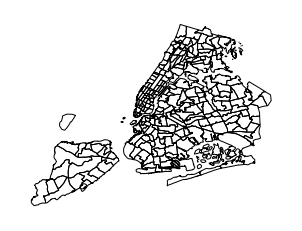

In [72]:
# Load the json file with county coordinates
json="https://raw.githubusercontent.com/DavidPachis/dataScience/main/proyecto/data/NY_map_zones.json"
geoData = gpd.read_file(json)
# Basic plot with just county outlines
gplt.polyplot(geoData, figsize=(20, 4));

### Limpieza y ordenamiento de los datos de entrada
Abrimos el dataset de taxis de Nueva York del 2020-06

In [18]:
#path="/content/drive/MyDrive/Colab Notebooks/CDA/yellow_tripdata_2020-06.csv"
file=wget.download('https://github.com/DavidPachis/dataScience/raw/main/proyecto/data/yellow_tripdata_2020-06.zip')
with zipfile.ZipFile('/content/yellow_tripdata_2020-06.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')
  

In [22]:
df=pd.read_csv('/content/yellow_tripdata_2020-06.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

Arreglamos los tipos de las columnas, para poder realizar operaciones futuras

In [24]:
df.fillna(0, inplace=True)
df["VendorID"] = df["VendorID"].astype(int)
df["passenger_count"] = df["passenger_count"].astype(int)
df["RatecodeID"] = df["RatecodeID"].astype(int)
df["payment_type"] = df["payment_type"].astype(int)
df['congestion_surcharge'] = df['congestion_surcharge'].astype(str)
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


Separamos las fechas y el tiempo de recogida y dejada

In [25]:
df['PUDate'] = df['tpep_pickup_datetime'].dt.date
df['PUTime'] = df['tpep_pickup_datetime'].dt.hour
df['DODate'] = df['tpep_dropoff_datetime'].dt.date
df['DOTime'] = df['tpep_dropoff_datetime'].dt.hour

In [26]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'PUDate', 'PUTime', 'DODate',
       'DOTime'],
      dtype='object')

Acá eliminamos las columnas que no ofrecen información o de las cuales ya sacamos información de ellas
Columna vendor ID, para nuestras preguntas de negocio, no ofrece ningún tipo de valor, por el momento
las columnas de fecha de recogida y llegada ya las utilizamos para extraer fecha y tiempo de recogida y llegada, por esta razón las podemos eliminar

In [27]:
df.drop(['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime'], axis=1, inplace=True)

In [ ]:
print(df.dtypes)
print(df.shape)

In [29]:
#df.profile_report()

Abrimos el dataset de zonas de Nueva York, que al igual que los demas archivos, se cargaron a un repositorio de github, para facilitar su acceso

In [33]:
path1="https://raw.githubusercontent.com/DavidPachis/dataScience/main/proyecto/data/zonesNY.csv"
zonesNY = pd.read_csv(path1)
zonesNY.head(10)

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights
5,6,Staten Island,Arrochar
6,7,Queens,Astoria
7,8,Queens,Astoria Park
8,9,Queens,Auburndale
9,10,Queens,Baisley Park


Unimos los datasets para obtener el nombre de los barrios y zonas de recogida

In [34]:
df1 = df.set_index('PULocationID').join(zonesNY.set_index('LocationID'))
df1 = df1.rename(columns={'Borough':'PUBorough','Zone':'PUZone'})

Unimos los datasets para obtener el nombre de los barrios y zonas de llegada

In [35]:
df1 = df1.set_index('DOLocationID').join(zonesNY.set_index('LocationID'))
df1 = df1.rename(columns={'Borough':'DOBorough','Zone':'DOZone'})
df1 = df1.assign(count=1) 

Organizamos las columnas

In [36]:
df1 = df1[['PUDate','PUTime','PUBorough','PUZone','DODate','DOTime','DOBorough','DOZone','passenger_count','trip_distance','RatecodeID','store_and_fwd_flag','payment_type','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','congestion_surcharge','total_amount','count']]
df1.head(5)

,PUDate,PUTime,PUBorough,PUZone,DODate,DOTime,DOBorough,DOZone,passenger_count,trip_distance,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,total_amount,count
1,2020-06-01,10,EWR,Newark Airport,2020-06-01,10,EWR,Newark Airport,1,0.00,...,1,50.00,0.0,0.5,10.16,0.0,0.3,0.0,60.96,1
1,2020-06-06,16,EWR,Newark Airport,2020-06-06,16,EWR,Newark Airport,3,0.00,...,1,92.00,0.0,0.0,0.00,0.0,0.3,0.0,92.30,1
1,2020-06-06,22,EWR,Newark Airport,2020-06-06,22,EWR,Newark Airport,6,0.06,...,1,3.00,0.5,0.5,0.86,0.0,0.3,0.0,7.11,1
1,2020-06-10,6,EWR,Newark Airport,2020-06-10,6,EWR,Newark Airport,3,0.00,...,3,0.01,0.0,0.0,0.00,0.0,0.3,0.0,0.31,1
1,2020-06-10,6,EWR,Newark Airport,2020-06-10,6,EWR,Newark Airport,3,0.00,...,1,65.00,0.0,0.0,0.00,0.0,0.3,0.0,65.30,1


## Analisis y desarrollo de preguntas de negocio 
Ya teniendo limpio y ordenado el Dataset procedemos a contestar las preguntas de negocio realizadas

### 1. ¿Cuáles son las zonas con menos y más afluencia de taxis? 
Hallamos las zonas de toma de taxi más populares, y las menos populares
tambiénn, lo discriminamos por recojida y dejada de pasajeros.

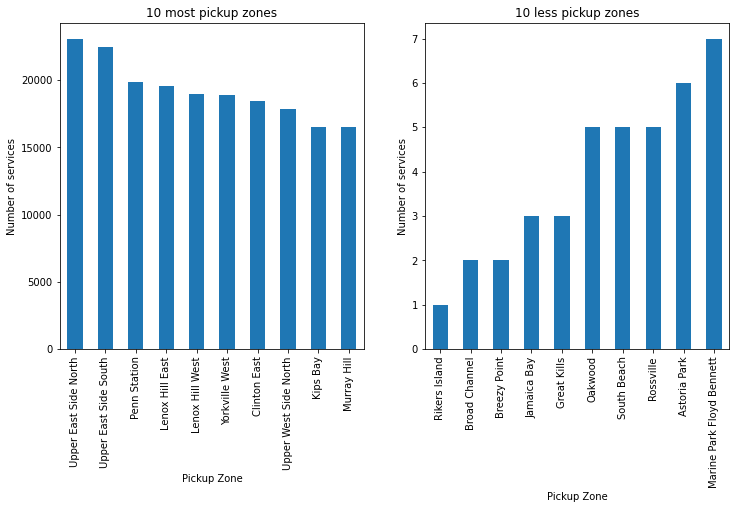

In [50]:
pt1 = df1.groupby(['PUZone']).size()
pt1head = pt1.sort_values(ascending = False).head(10)
pt1last = pt1.sort_values(ascending = False).tail(10)
fig, (ax1 , ax2) = plt.subplots(1,2, figsize=(12,6))
pt1head.plot(kind = 'bar', ax = ax1 , ylabel ='Number of services' , xlabel ='Pickup Zone',)
ax1.set_title("10 most pickup zones")

pt1last.plot(kind = 'bar', ax = ax2 , ylabel ='Number of services' , xlabel ='Pickup Zone',)
ax2.set_title("10 less pickup zones")
ax2.invert_xaxis()


Graficamos también en diagrama de torta, para entender vizualmente la proporcion del top y tail 10 de las zonas de pick up de taxis. 

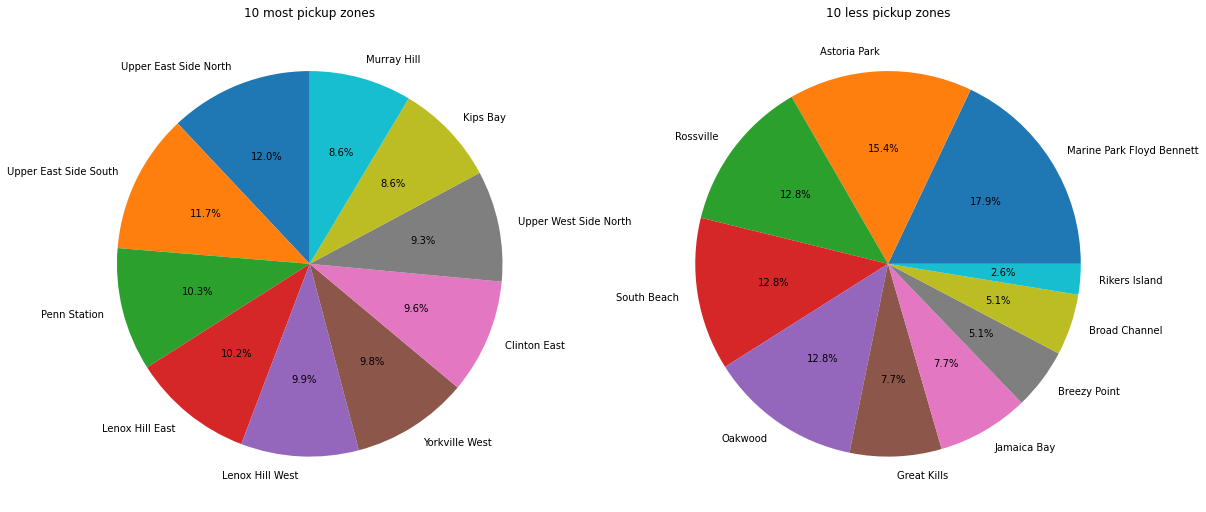

In [71]:

fig, (ax1 , ax2) = plt.subplots(1,2, figsize=(19,12))
pt1head.plot(kind = 'pie', ax = ax1 , ylabel ='',startangle=90, autopct='%1.1f%%')
ax1.set_title("10 most pickup zones")


pt1last.plot(kind = 'pie', ax = ax2 , ylabel ='', autopct='%1.1f%%')
ax2.set_title("10 less pickup zones")


plt.show()

Hallamos las zonas de destino más populares

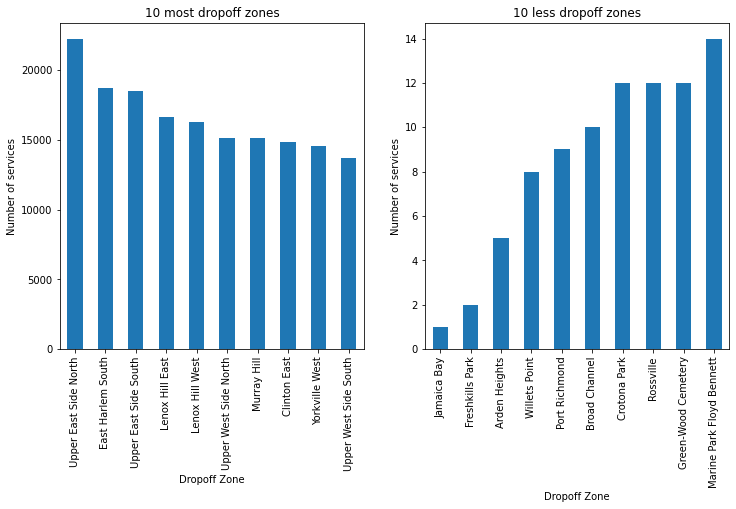

In [57]:
pt1a = df1.groupby(['DOZone']).size()
pt1heada = pt1a.sort_values(ascending = False).head(10)
pt1lasta = pt1a.sort_values(ascending = False).tail(10)

fig, (ax1 , ax2) = plt.subplots(1,2, figsize=(12,6))
pt1heada.plot(kind = 'bar', ax = ax1 , ylabel ='Number of services' , xlabel ='Dropoff Zone',)
ax1.set_title("10 most dropoff zones")

pt1lasta.plot(kind = 'bar', ax = ax2 , ylabel ='Number of services' , xlabel ='Dropoff Zone',)
ax2.set_title("10 less dropoff zones")
ax2.invert_xaxis()

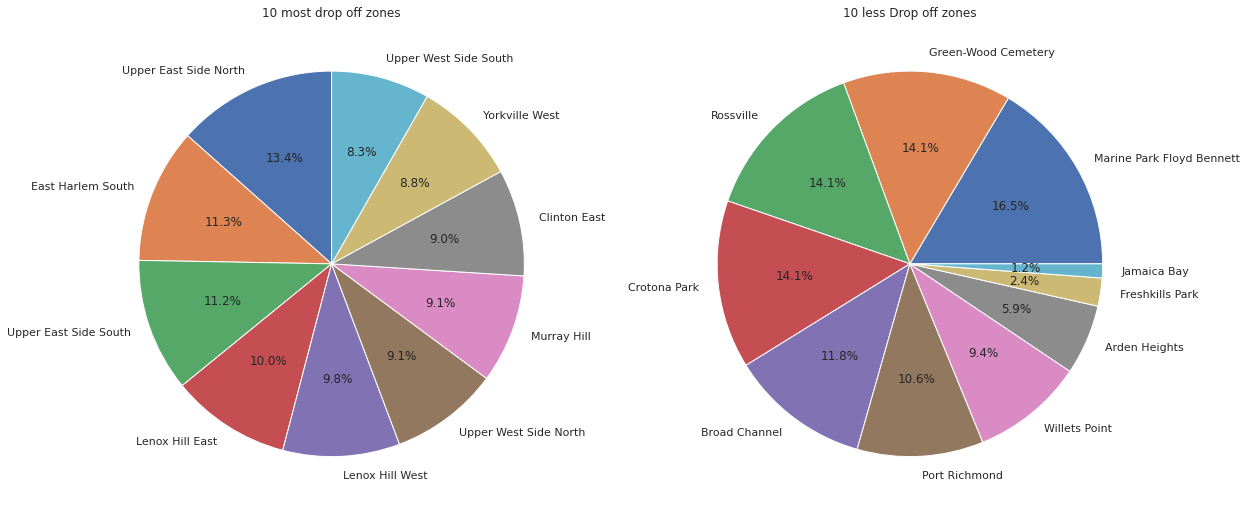

In [80]:
fig, (ax1 , ax2) = plt.subplots(1,2, figsize=(19,12))
pt1heada.plot(kind = 'pie', ax = ax1 , ylabel ='',startangle=90, autopct='%1.1f%%')
ax1.set_title("10 most drop off zones")


pt1lasta.plot(kind = 'pie', ax = ax2 , ylabel ='', autopct='%1.1f%%')
ax2.set_title("10 less Drop off zones")

plt.show()

###2. ¿Existe una zona donde se pague más propina que las otras?

RTA: Donde más se da propina son los viajes al aeropuerto JFK pero en promedio se dan mas propinas en el aeropuerto de Newwark


PUZone
Newark Airport                  8.866000
Glen Oaks                       7.729412
JFK Airport                     5.351381
Flushing Meadows-Corona Park    4.681455
Breezy Point                    4.600000
LaGuardia Airport               4.167938
East Elmhurst                   3.334352
Mariners Harbor                 3.257812
Cobble Hill                     3.119576
Pelham Bay Park                 3.001053
Name: tip_amount, dtype: float64


Text(0.5, 1.0, '10 most tipped zones (average)')

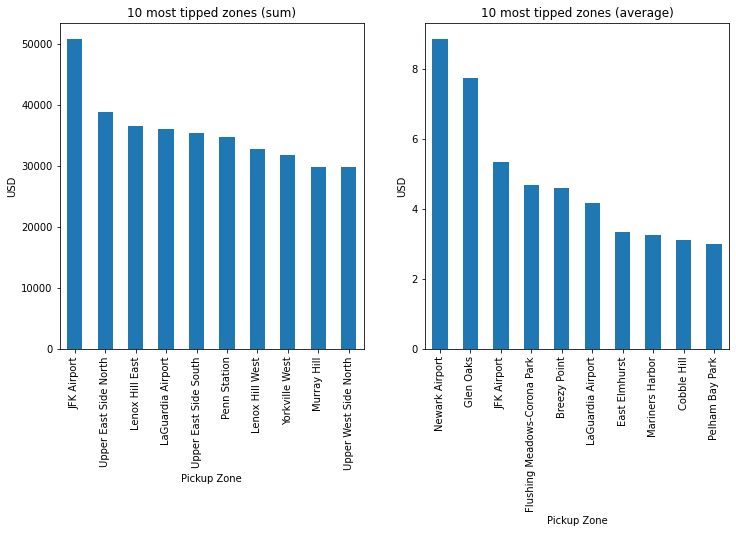

In [ ]:
pt2a = df1.groupby(['PUZone']).agg({'tip_amount':sum})
pt2b = df1.groupby(['PUZone']).agg({'tip_amount':np.mean})
pt2a = pt2a['tip_amount'].sort_values(ascending = False).head(10)
pt2b = pt2b['tip_amount'].sort_values(ascending = False).head(10)

print(pt2b)
fig, (ax1 , ax2) = plt.subplots(1,2, figsize=(12,6))
pt2a.plot(kind = 'bar', ax = ax1 , ylabel ='USD' , xlabel ='Pickup Zone',)
ax1.set_title("10 most tipped zones (sum)")

pt2b.plot(kind = 'bar', ax = ax2 , ylabel ='USD' , xlabel ='Pickup Zone',)
ax2.set_title("10 most tipped zones (average)")


### 3. ¿Cuál es la zona con más servicios de taxis en Nueva York? 
RTA: UPPER EAST SIDE NORTH

Text(0.5, 1.0, '10 Most Serviced Zones')

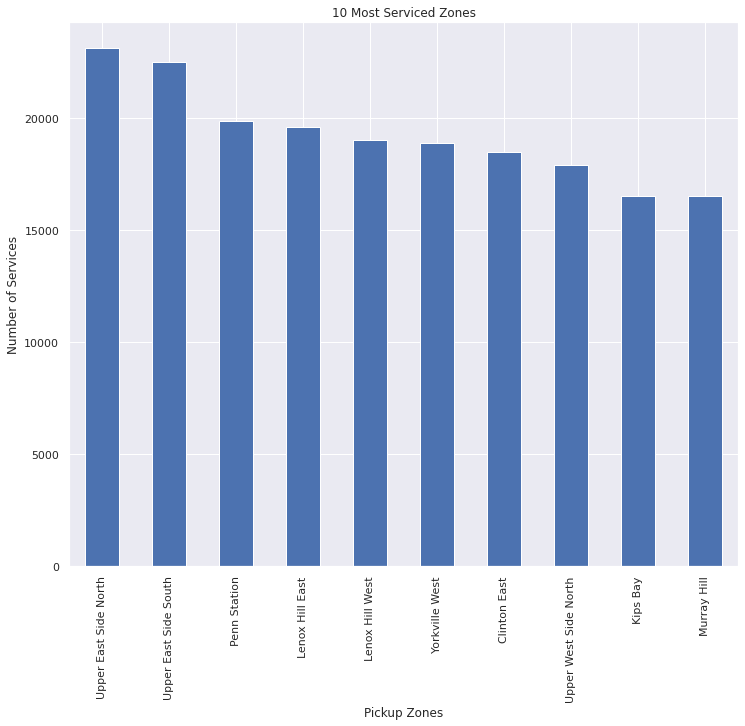

In [82]:
pt1head.plot(kind = 'bar')
plt.xlabel("Pickup Zones")
plt.ylabel("Number of Services")
plt.title("10 Most Serviced Zones")

### 4. ¿Cuál es la zona/hora de más recogidas en la ciudad, cuál sería la menos congestionada? 

PUZone                 PUTime
Upper East Side North  14        2207
                       13        2186
                       12        2107
Upper East Side South  15        2095
                       12        2068
                       14        2036
                       16        1994
Upper East Side North  11        1982
Upper East Side South  13        1973
Upper East Side North  15        1931
                       10        1875
Penn Station           6         1828
Upper East Side South  17        1827
                       11        1678
Upper East Side North  16        1595
                       17        1576
Murray Hill            15        1551
Upper East Side North  9         1549
Lenox Hill East        14        1520
Lenox Hill West        13        1508
Name: count, dtype: int64

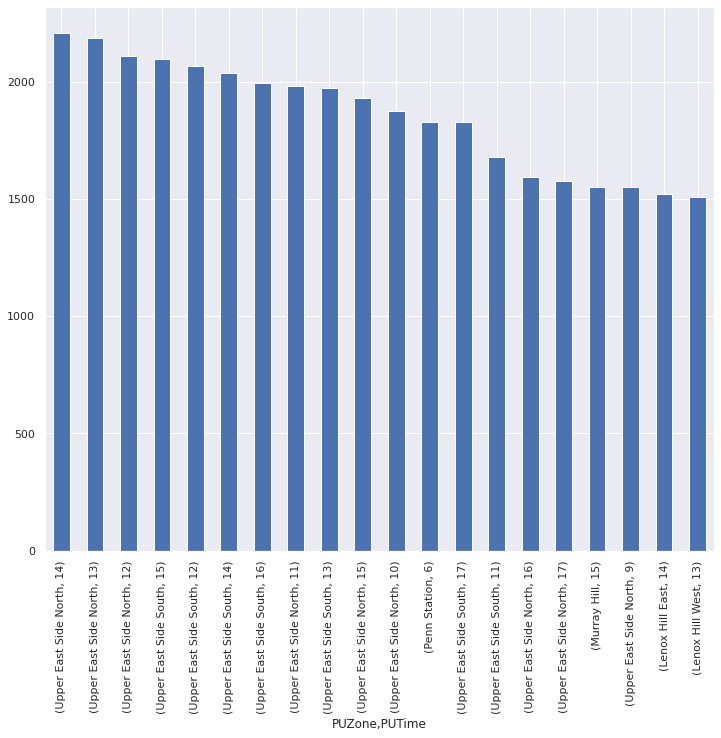

In [94]:
pt4 = df1.groupby(['PUZone','PUTime']).agg({'count':sum})
pt4 = pt4['count'].sort_values(ascending = False).head(20)
pt4.plot(kind='bar')
pt4

### 5. ¿Cuál es el número de pasajeros promedio por viaje?
 RTA: 1.23 pasajeros en promedio

In [ ]:

pt5 = df1['passenger_count'].mean()
pt5

1.2310389988358557

### 6. ¿Qué recomendaciones darían para que un taxista tenga más ingresos?  

Recomendaciones para el taxi

Si quiere estar ocupado todo el día, pasarse por la zona de  Up East Side North, que es donde llaman más taxis (mas de 20.000 servicios al mes)

Si quiere los montos más grandes por carrera tiene que irse a Rossville con USD 123 en promedio por viaje

Por último, si quiere ganar más propinas, tiene que irse a el aeropuerto JFK, pero en promedio el destino de recogidas que más da es el aeropuerto de Newark

En general, un punto donde se pueden tener buenas propinas (promedio) y tiene un buen monto por carrera es el aeropuerto de Newark!!

Text(0.5, 1.0, '10 Most total amount pickups (average)')

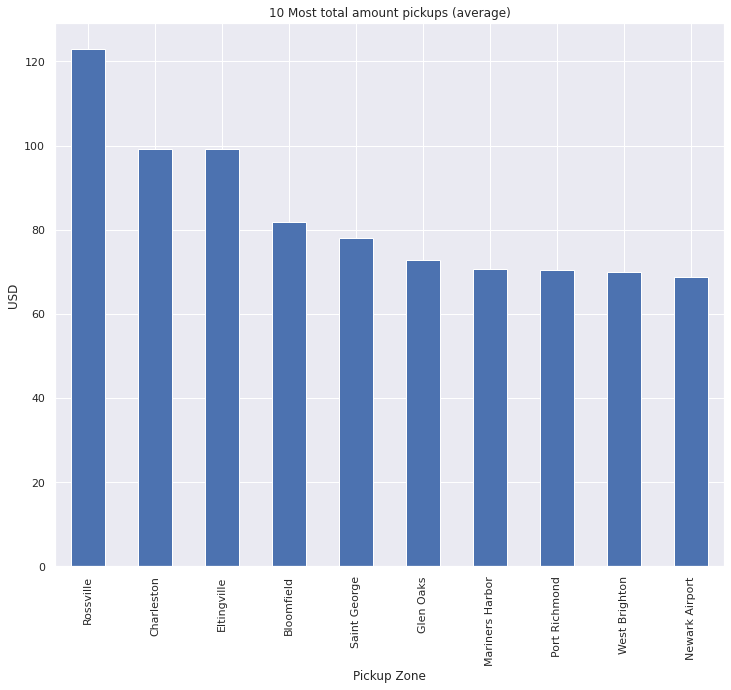

In [84]:
pt6 = df1.groupby(['PUZone']).agg({'total_amount':np.mean})
pt6 = pt6['total_amount'].sort_values(ascending = False).head(10)
pt6.plot(kind = "bar")
plt.ylabel("USD")
plt.xlabel("Pickup Zone")
plt.title("10 Most total amount pickups (average)")

### 7. ¿cuales son las zonas con más cobros por congestion?

Text(0.5, 1.0, '10 most congestion surcharge zones')

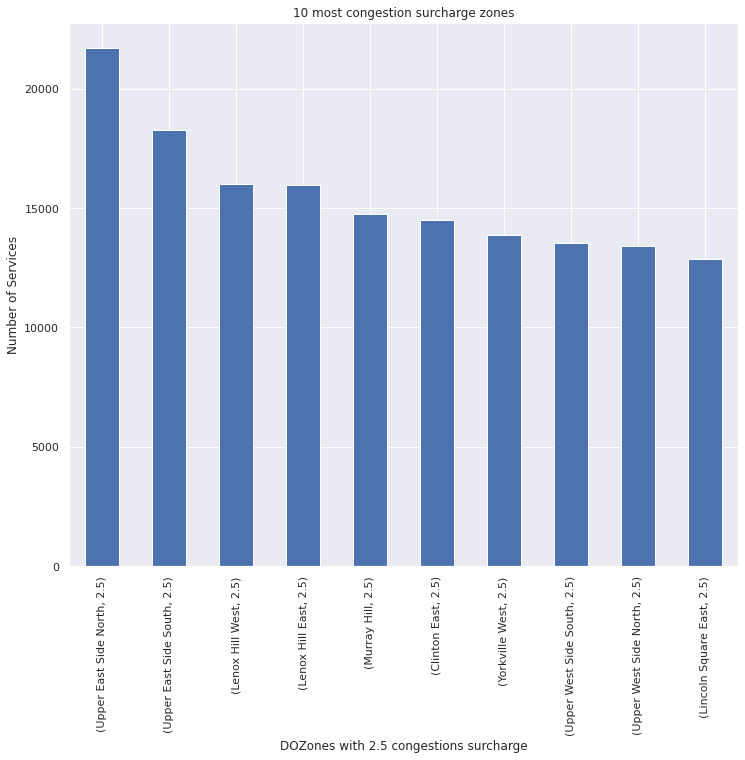

In [88]:
pt7 = df1.groupby(['DOZone','congestion_surcharge']).agg({'count':sum})
pt7_Total = pt7['count'].sort_values(ascending = False)
pt7 = pt7['count'].sort_values(ascending = False).head(10)
pt7.plot(kind = 'bar')
plt.xlabel("DOZones with 2.5 congestions surcharge")
plt.ylabel("Number of Services")
plt.title("10 most congestion surcharge zones")


In [ ]:
pt7_Total 

In [ ]:
fullData = geoData.merge(pt7_Total, left_on=['zone'], right_on=['DOZone'])
fullData.head(10)


Acá se presenta el mapa de calor, de las zonas con mayor cantidad de cobros por congestion de New York, las zonas mas oscuro corresponden a las zonas de la grafia de barras anterior, donde se listan el top de zonas del ranking.

Text(0.5, 1.0, 'Colorplet most congestions Zones')

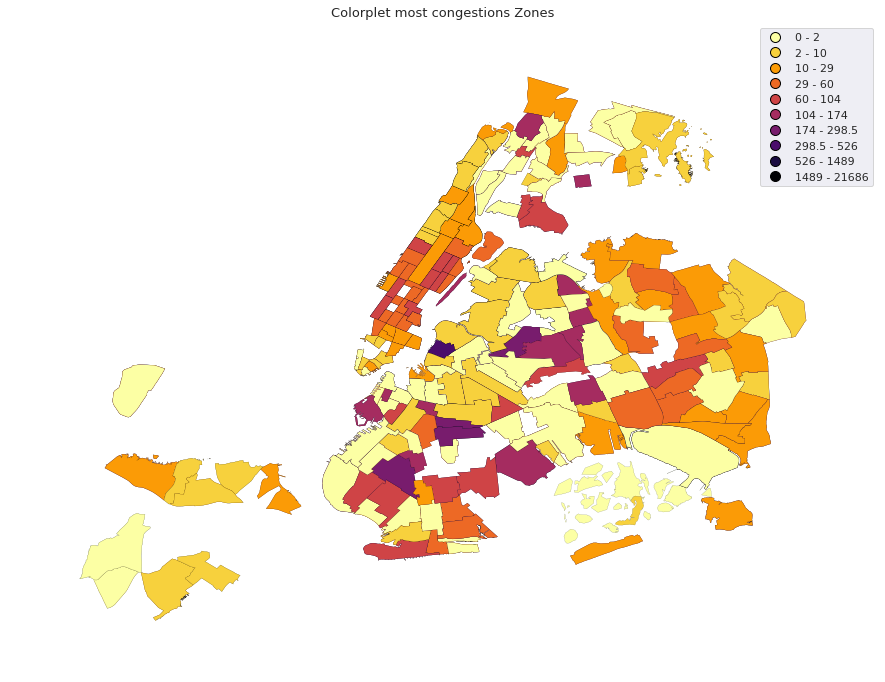

In [92]:
# Initialize the figure
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Set up the color sheme:
import mapclassify as mc
scheme = mc.Quantiles(fullData['count'], k=10)

# Map
gplt.choropleth(fullData, 
    hue="count", 
    linewidth=.1,
    scheme=scheme, cmap='inferno_r',
    legend=True,
    edgecolor='black',
    ax=ax
)

ax.set_title('Colorplet most congestions Zones', fontsize=13)

En esta Gráfica se ve un scatter plot, en el cual se relacionan 3 de las variables más destacadas a mostrar a la empresa, pues muestra las mayores zonas de tips por un total por zona, contrastando la cantidad total de viajes junto con el total del cargo del viaje. 

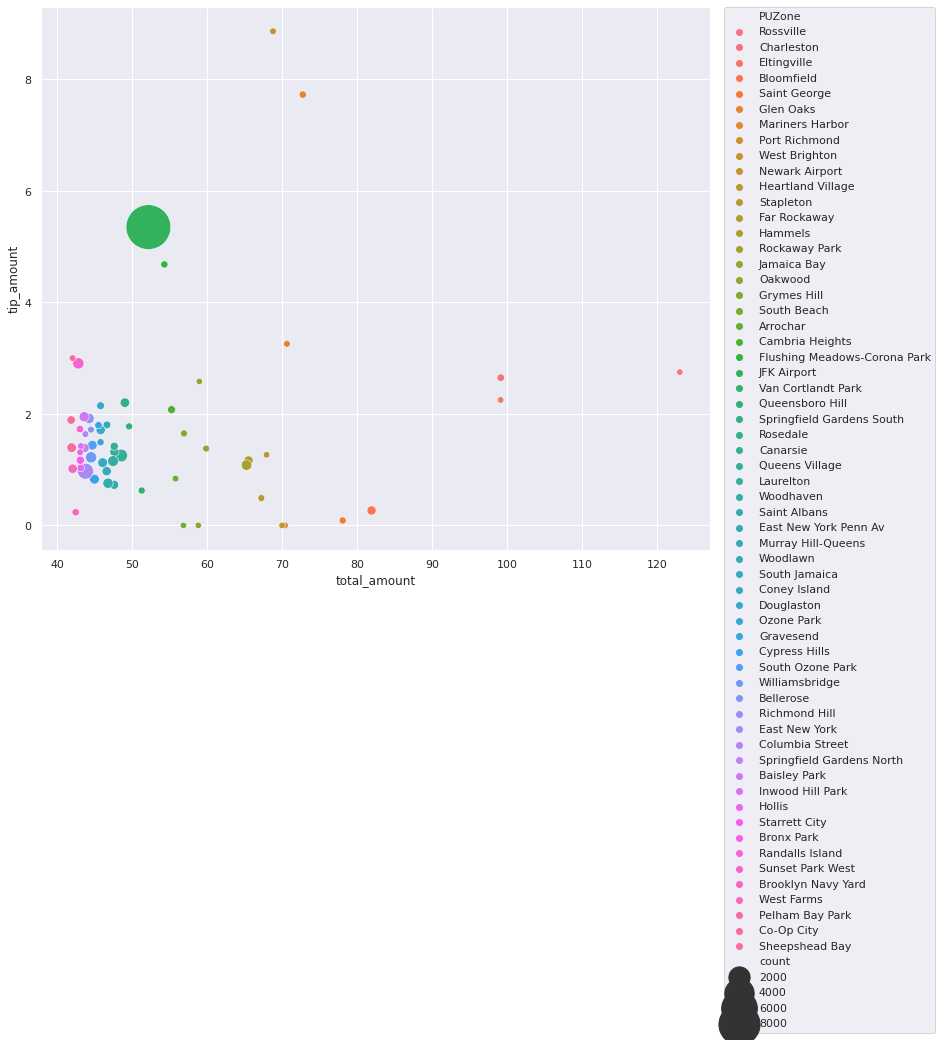

In [93]:
pt8tip = df1.groupby('PUZone', as_index=False).agg({'tip_amount':np.mean})
pt8amount = df1.groupby('PUZone', as_index=False).agg({'total_amount':np.mean})
pt8NOfServ = df1.groupby('PUZone', as_index=False).agg({'count':sum})


pt8a = pt8tip.set_index('PUZone').join(pt8amount.set_index('PUZone')).join(pt8NOfServ.set_index('PUZone'))
pt8a = pt8a.sort_values(by=['total_amount'],ascending = False).head(60)
#print(pt8a)
# use the scatterplot function to build the bubble map
sns.set(rc={'figure.figsize':(12,10)})
ax = sns.scatterplot(data=pt8a, x="total_amount", y="tip_amount", size="count", sizes=(40, 2000),hue='PUZone')
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1,1))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)



# New Section